In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import cdist
from sklearn import metrics

In [2]:
trip = pd.read_csv('trim_bay_2min_6hours.csv', index_col=False)

In [3]:
trip.head()

,Unnamed: 0,Unnamed: 0.1,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code,city
0,10,10,4549,125,2013-08-29 13:52:00,Spear at Folsom,49,2013-08-29 13:55:00,Embarcadero at Bryant,54,368,Subscriber,94109,San Francisco
1,11,11,4498,126,2013-08-29 13:23:00,San Pedro Square,6,2013-08-29 13:25:00,Santa Clara at Almaden,4,26,Subscriber,95112,San Jose
2,12,12,4965,129,2013-08-29 19:32:00,Mountain View Caltrain Station,28,2013-08-29 19:35:00,Mountain View Caltrain Station,28,140,Subscriber,94041,Mountain View
3,13,13,4557,130,2013-08-29 13:57:00,2nd at South Park,64,2013-08-29 13:59:00,2nd at South Park,64,371,Subscriber,94122,San Francisco
4,14,14,4386,134,2013-08-29 12:31:00,Clay at Battery,41,2013-08-29 12:33:00,Beale at Market,56,503,Subscriber,94109,San Francisco


# Kmeans for one bike

570

In [4]:
def timedifference(row):

    #print(row['start_date'])
    
    startdifference = ((row['start_date']-initialstart)/np.timedelta64(1, 'h'))
    #print(type(startdifference))
    enddifference   = ((row['end_date']-initialend)/np.timedelta64(1, 'h'))
    
    return pd.Series((startdifference, enddifference))


In [5]:
def sil_cal_elbow(X, start, end):
    result_list = []
    for n in range(start, end+1):
        kmeans = KMeans(n_clusters=n)
        p = kmeans.fit(X)
        t = metrics.silhouette_score(X, p.labels_)
        result_list.append(t)
    return result_list

In [6]:
def generatetraining(choose_id):
    global initialstart
    global initialend
    test = trip[trip.bike_id == choose_id]
    test = test.sort_values('start_date')
    test['start_date']=pd.to_datetime(test['start_date'].values)
    test['end_date']=pd.to_datetime(test['end_date'].values)
    initialstart = test.iloc[0].start_date
    initialend   = test.iloc[0].end_date
    training_feature  = test.apply(timedifference, axis=1)
    training_feature.columns = ['start_diff', 'end_diff']
    
    return training_feature

In [7]:
def siloutteplot(training_feature):

    t = sil_cal_elbow(training_feature, 2, 10)
    
    fig, ax = plt.subplots(figsize = [15,15], facecolor=[0.9,0.9,0.9])

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    ax.xaxis.set_ticks_position('bottom')

    ax.yaxis.set_ticks_position('left')


    x_axis=list(range(2,11))
    y_axis=t

    ax.plot(x_axis, t, 'b*-')

    plt.xlabel('K')
    plt.ylabel('Coefficient (1 is best, -1 is worst)')
    plt.title('Silhouette coefficient')

    plt.show()
    

In [8]:
def clusterplot(K, training_feature):
    km = KMeans(K)
    km.fit(training_feature)
    mu = km.cluster_centers_
    labels = km.labels_
    
    fig, ax = plt.subplots(figsize = [15,15], facecolor=[0.9,0.9,0.9])

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    ax.xaxis.set_ticks_position('bottom')

    ax.yaxis.set_ticks_position('left')


    #x_axis=TempIndex[0]
    #y_axis=life_cycle.duration

    ax.scatter(training_feature['start_diff'], training_feature['end_diff'], c=labels, alpha=0.4)
    ax.scatter(mu[:,0], mu[:,1], s=300, c=np.unique(labels))
    #for i in range(len(label_list)):
        #ax.text(mu[:,0][i], mu[:,1][i]*1.01, label_list[i], fontsize= 18)

    plt.xlabel('start time')
    plt.ylabel('end time')


    plt.show()


In [ ]:
342

In [24]:
id_set = trip.bike_id.unique()

choose_id = np.random.choice(id_set, 1)[0]

choose_id

342

In [12]:
training_feature = generatetraining(342)

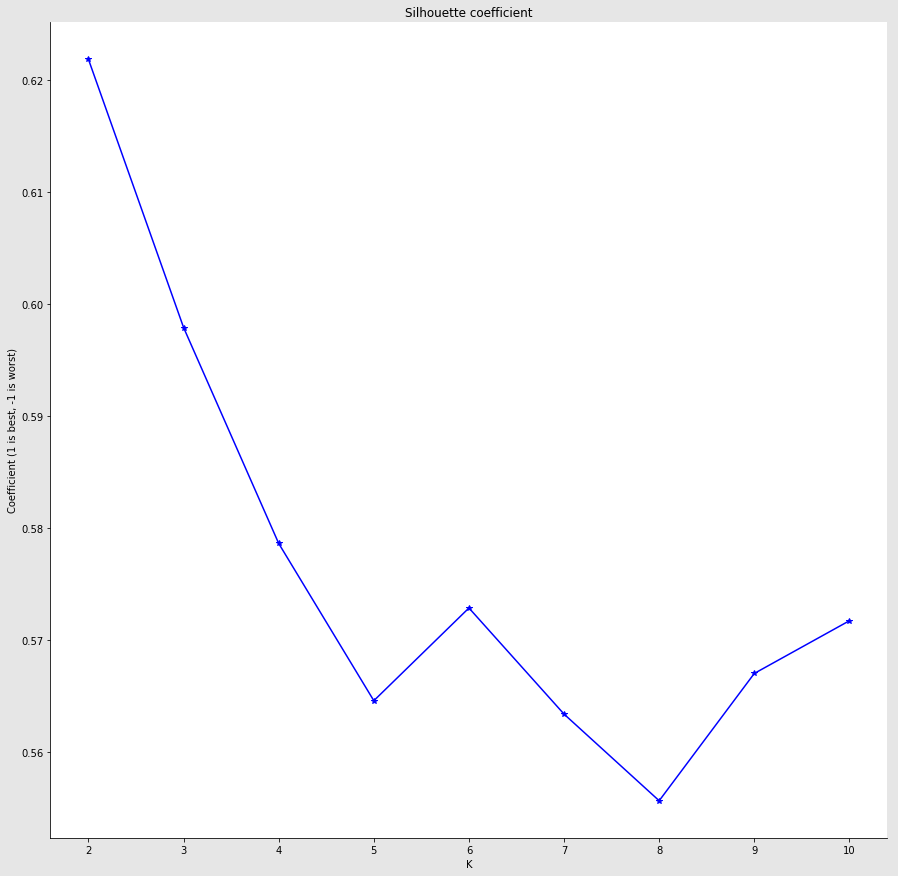

In [13]:
siloutteplot(training_feature)

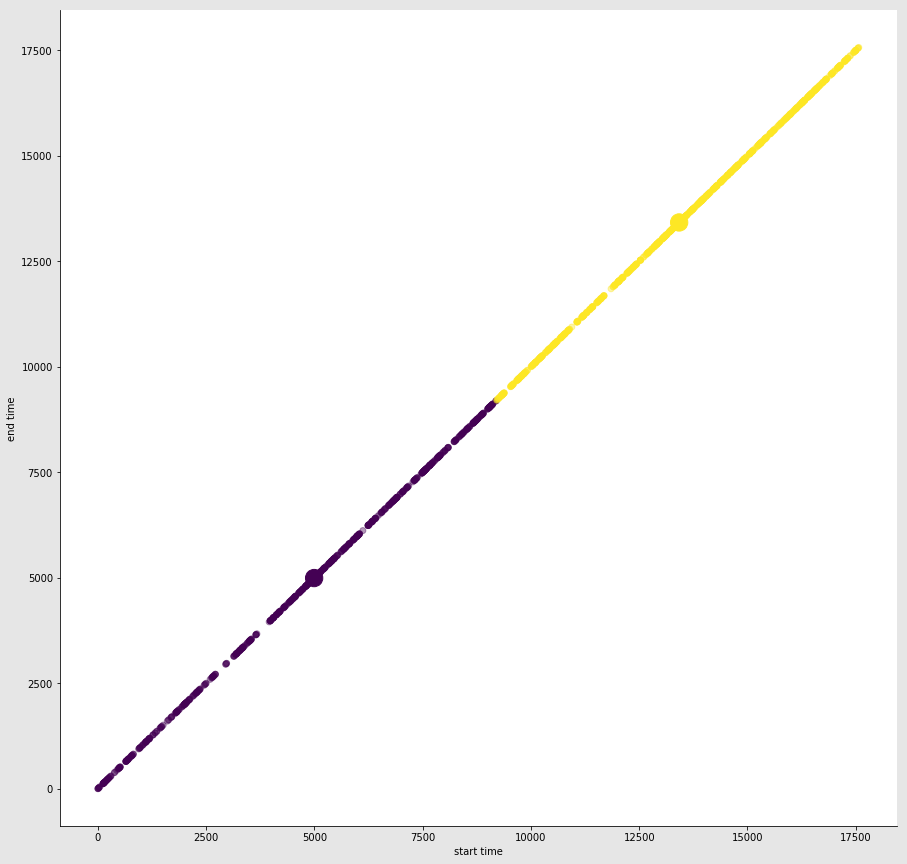

In [14]:
clusterplot(2, training_feature)

In [36]:
len(training_feature)

1563

## Get bike group use Kmeans+siloutte

In [28]:
def getlabelist(labels):
    label_list = []
    for i in labels:
        if i not in label_list:
            label_list.append(i)
    return label_list

In [396]:
def sil_cal(X, start=2, end=10):
    result_dict = {}
    result_list = []
    for n in range(start, end+1):
        kmeans = KMeans(n_clusters=n, random_state=0)
        p = kmeans.fit(X)
        t = metrics.silhouette_score(X, p.labels_)
        result_list.append(t)
        result_dict[t] = n
    return result_dict[max(result_list)] # return the best result and the K value

In [431]:
def reorderlable(row):
    #print(label_list)
    subgroup = str(label_list.index(row.group))
    bike = str(row.bike_id)
    return bike+'_'+subgroup

In [522]:
def getbikegroup(dataset):
    global initialstart
    global initialend
    global label_list
    global X
    final_id_list = []
    coverted_pd = pd.DataFrame()
    bikeid_set = set(dataset.bike_id.unique())
    #print(bikeid_set)
    for bikeid in bikeid_set:  
        temp = dataset[dataset.bike_id == bikeid]
        temp = temp.sort_values('start_date')
        temp['start_date']=pd.to_datetime(temp['start_date'].values)
        temp['end_date']=pd.to_datetime(temp['end_date'].values)
        initialstart = temp.iloc[0].start_date
        initialend   = temp.iloc[0].end_date

        #print(initialstart)
        X = temp.apply(timedifference, axis=1)
        X.columns = ['start_diff', 'end_diff']
        # to avoid the number of sample is very small
        if len(X)/10 > 10:
            end_number = 10
        elif len(X)/10 < 1:
            end_number = 1
        else:
            end_number = int(len(X)/10)
            
        #print(end_number)
        
        if end_number == 1:
            best_K = 1
        else:
            best_K = sil_cal(X, start=2, end=end_number)
        print(bikeid, best_K)
        km = KMeans(best_K)
        km.fit(X)
        centroids = km.cluster_centers_
        labels = km.labels_
        label_list = getlabelist(labels)

        #print(label_list)
        
        result = pd.DataFrame(labels, columns = ['group'], index=temp.index)
        temp = pd.concat([temp, result], axis =1)
        temp['bike_group'] = temp.apply(reorderlable, axis=1)

        final_id = str(bikeid) + '_' + str(max(label_list))
        final_id_list.append(final_id)
        #print(final_id_list)
        
        coverted_pd = pd.concat([coverted_pd, temp])
        
    return coverted_pd, final_id_list

In [523]:
dataset = trip[trip.bike_id == 876]

In [524]:
dataset

,Unnamed: 0,Unnamed: 0.1,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code,city
238414,241626,241626,298806,390,2014-05-27 07:30:00,Embarcadero at Sansome,60,2014-05-27 07:37:00,Beale at Market,56,876,Subscriber,94111,San Francisco
239025,242247,242247,297926,799,2014-05-25 19:05:00,Davis at Jackson,42,2014-05-25 19:19:00,Embarcadero at Bryant,54,876,Subscriber,94111,San Francisco
241624,244891,244891,294522,1349,2014-05-22 12:52:00,Embarcadero at Bryant,54,2014-05-22 13:14:00,Embarcadero at Vallejo,48,876,Customer,76031,San Francisco
241715,244982,244982,294416,463,2014-05-22 11:42:00,Embarcadero at Vallejo,48,2014-05-22 11:50:00,Embarcadero at Bryant,54,876,Subscriber,94105,San Francisco
241765,245033,245033,294339,231,2014-05-22 10:20:00,Steuart at Market,74,2014-05-22 10:24:00,Embarcadero at Vallejo,48,876,Subscriber,95130,San Francisco


In [525]:
coverted_pd, final_id_list = getbikegroup(trip)

9 8
10 6
11 5
12 7
13 4
14 3
15 7
16 3
17 10
18 5
19 5
20 6
21 4
22 6
23 7
24 6
25 3
26 2
27 6
28 5
29 2
30 4
31 9
32 9
33 2
34 3
35 3
36 3
37 2
38 2
39 2
40 2
41 10
42 6
43 10
44 3
45 5
46 2
47 3
48 6
49 2
50 10
51 8
52 6
53 10
54 8
55 2
56 3
57 2
58 4
59 6
60 10
61 2
62 2
63 5
64 4
65 8
66 4
67 3
68 6
69 9
70 2
71 8
72 4
74 9
75 9
76 3
77 4
78 2
79 3
80 2
81 10
82 9
83 9
84 9
85 3
86 3
87 9
88 10
89 6
90 3
91 2
92 2
93 7
94 5
95 2
96 3
97 2
98 2
99 10
100 3
101 3
102 10
103 2
104 2
105 3
106 6
107 2
108 6
109 3
110 2
111 2
112 3
116 4
117 2
118 2
119 10
120 7
121 3
122 3
123 10
124 10
125 2
126 3
127 8
128 4
129 2
130 2
131 10
132 4
133 2
134 7
135 10
136 2
137 2
138 10
139 2
140 8
141 3
142 2
143 10
144 4
145 2
146 5
147 3
148 8
149 10
150 3
151 2
152 2
153 4
154 9
155 4
156 3
157 3
158 5
159 3
160 4
161 10
162 3
163 2
164 3
165 2
167 2
168 3
174 2
175 10
176 8
177 4
178 3
179 10
180 10
181 2
182 6
183 5
184 2
185 6
186 4
187 3
188 3
189 2
190 2
191 4
192 2
193 4
194 2
195 4
196 2
1

In [526]:
coverted_pd_removelast = coverted_pd[~coverted_pd['bike_group'].isin(final_id_list)]

In [527]:
coverted_pd.to_csv('trip_kmeans.csv')
coverted_pd_removelast.to_csv('trip_kmeans_removelast.csv')

In [528]:
coverted_pd.bike_group.unique()

array(['9_0', '9_1', '9_2', ..., '877_1', '878_0', '878_1'], dtype=object)

In [529]:
coverted_pd_removelast.bike_group.unique()

array(['9_0', '9_1', '9_2', ..., '740_0', '877_0', '878_0'], dtype=object)